<a href="https://colab.research.google.com/github/Sergius-DS/RedSmart__energy_forecasting/blob/main/FINAL_Demanda_electrica_skforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 18.0 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from skforecast.recursive import ForecasterRecursive

In [ ]:
data = pd.read_excel("DemandaCOES_.xlsx",skiprows=3)

In [ ]:
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d/%m/%Y %H:%M')
data.set_index('FECHA',inplace=True)
data.rename(columns={'EJECUTADO':'Demand'},inplace=True)
data = data.asfreq("30min")
data.head()

,Demand
FECHA,
2023-01-01 00:30:00,6120.78000
2023-01-01 01:00:00,6010.91339
2023-01-01 01:30:00,5946.83300
2023-01-01 02:00:00,5846.17000
2023-01-01 02:30:00,5756.13500


In [ ]:
data.index

DatetimeIndex(['2023-01-01 00:30:00', '2023-01-01 01:00:00',
               '2023-01-01 01:30:00', '2023-01-01 02:00:00',
               '2023-01-01 02:30:00', '2023-01-01 03:00:00',
               '2023-01-01 03:30:00', '2023-01-01 04:00:00',
               '2023-01-01 04:30:00', '2023-01-01 05:00:00',
               ...
               '2024-08-31 19:30:00', '2024-08-31 20:00:00',
               '2024-08-31 20:30:00', '2024-08-31 21:00:00',
               '2024-08-31 21:30:00', '2024-08-31 22:00:00',
               '2024-08-31 22:30:00', '2024-08-31 23:00:00',
               '2024-08-31 23:30:00', '2024-09-01 00:00:00'],
              dtype='datetime64[ns]', name='FECHA', length=29232, freq='30min')

## VISUALIZANDO SERIE

<Axes: xlabel='FECHA'>

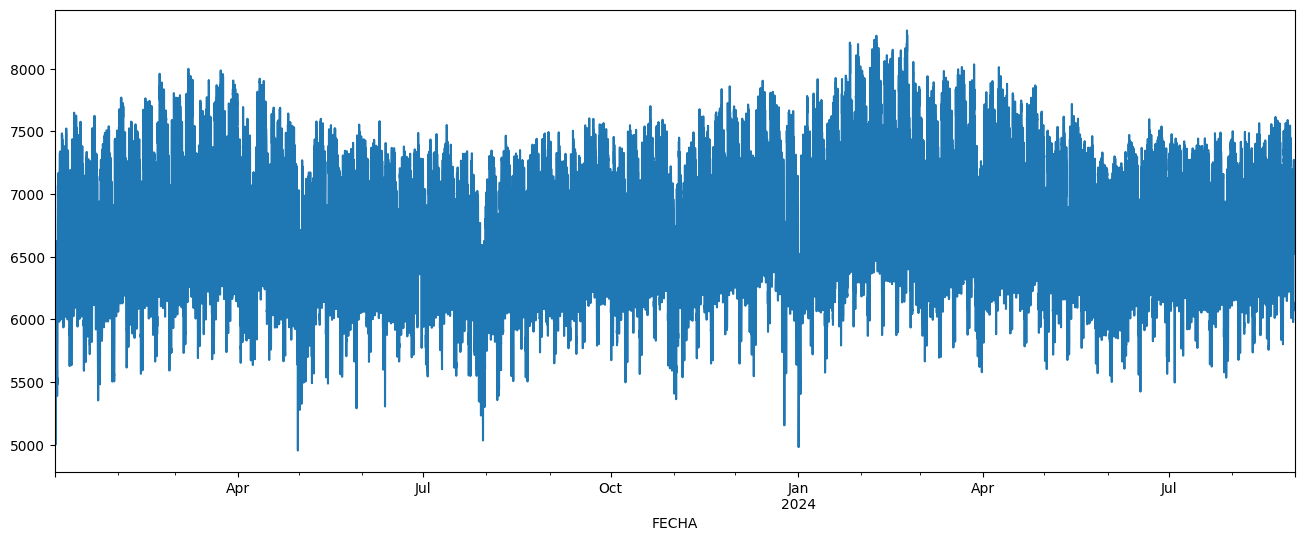

In [ ]:
data.Demand.plot(figsize=(16,6))

## ANALISIS DE TENDENCIA

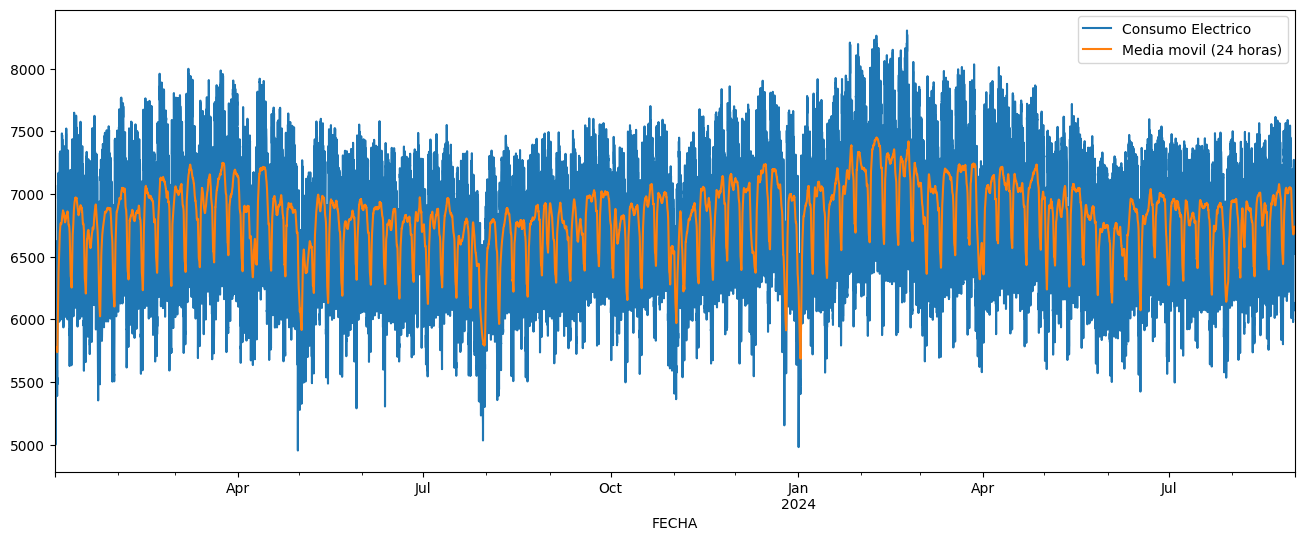

In [ ]:
data.Demand.plot(figsize=(16,6),label="Consumo Electrico")
data.Demand.rolling(48).mean().plot(label='Media movil (24 horas)')
plt.legend()
plt.show()

## ANALISIS DE TENDENCIA SEMANAL

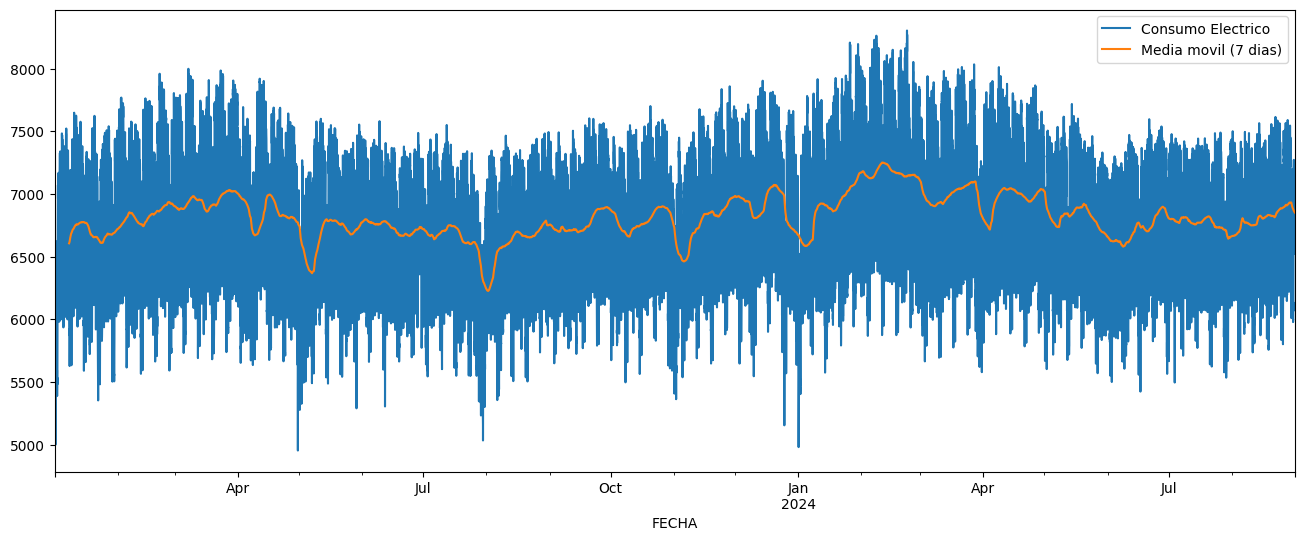

In [ ]:
data.Demand.plot(figsize=(16,6),label="Consumo Electrico")
data.Demand.rolling(48*7).mean().plot(label='Media movil (7 dias)')
plt.legend()
plt.show()

## ANALISIS DE TENDENCIA PRIMERA SEMANA

<Axes: xlabel='FECHA'>

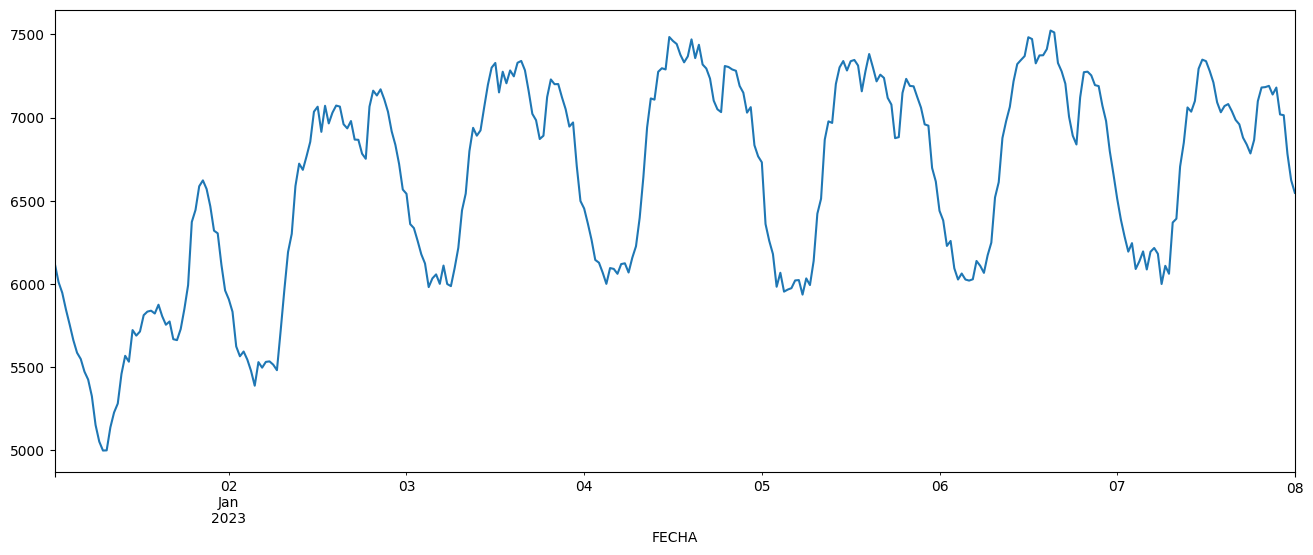

In [ ]:
data.Demand[:(48*7)].plot(figsize=(16, 6))

## ANALISIS DE TENDENCIA 24 HORAS

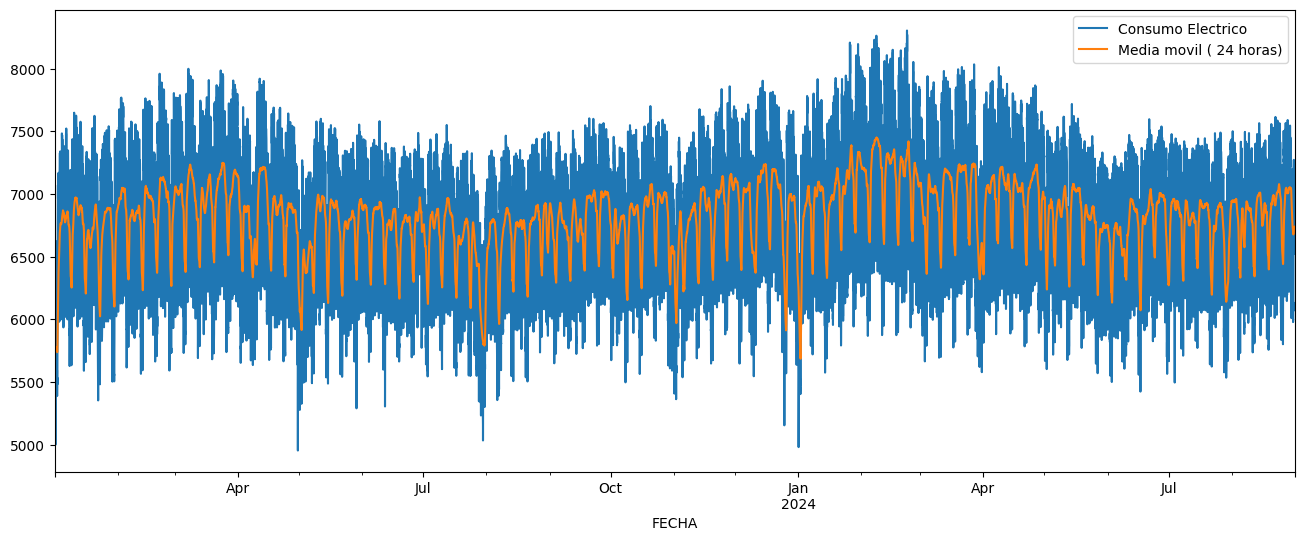

In [ ]:
data.Demand.plot(figsize=(16, 6), label="Consumo Electrico")
data.Demand.rolling(48).mean().plot(label='Media movil ( 24 horas)')
plt.legend()
plt.show()

## FEATURING ENGINEERING

## EFECTO CICLICO

In [ ]:
data['ciclo'] = data.index.map(lambda t: (t.hour * 60 + t.minute) / (24 * 60))

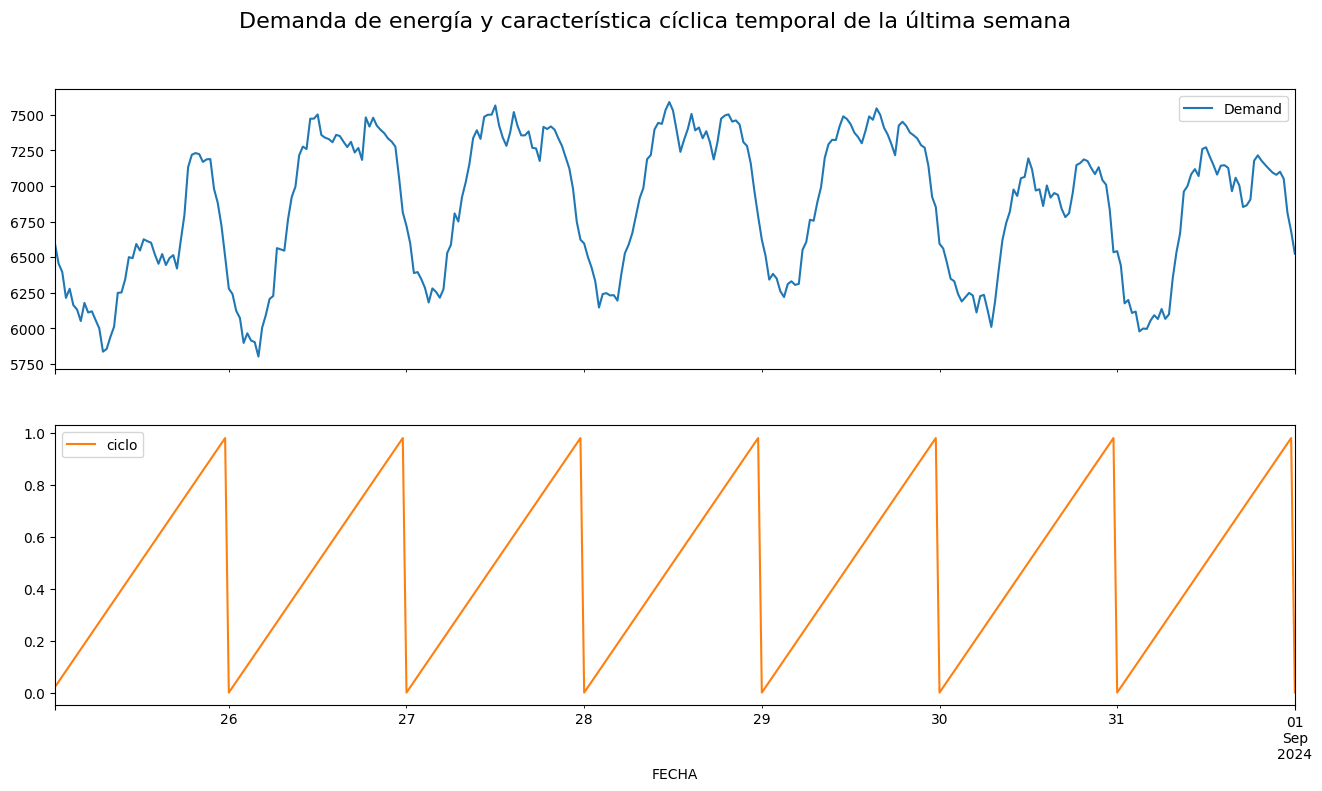

In [ ]:
data[['Demand','ciclo']][-48*7:].plot(figsize=(16,8),subplots=True)
plt.suptitle('Demanda de energía y característica cíclica temporal de la última semana', fontsize=16)
plt.show()

## EFECTO DIARIO

In [ ]:
days_translation = {
    'Monday': '1Lunes',
    'Tuesday': '2Martes',
    'Wednesday': '3Miércoles',
    'Thursday': '4Jueves',
    'Friday': '5Viernes',
    'Saturday': '6Sábado',
    'Sunday': '0Domingo'
}


In [ ]:
data['dia'] = data.index.day_name().map(days_translation)

In [ ]:
data2 = pd.get_dummies(data,columns=['dia'], dtype=int)

In [ ]:
data2.columns

Index(['Demand', 'ciclo', 'dia_0Domingo', 'dia_1Lunes', 'dia_2Martes',
       'dia_3Miércoles', 'dia_4Jueves', 'dia_5Viernes', 'dia_6Sábado'],
      dtype='object')

In [ ]:
data2.head()

,Demand,ciclo,dia_0Domingo,dia_1Lunes,dia_2Martes,dia_3Miércoles,dia_4Jueves,dia_5Viernes,dia_6Sábado
FECHA,,,,,,,,,
2023-01-01 00:30:00,6120.78000,0.020833,1,0,0,0,0,0,0
2023-01-01 01:00:00,6010.91339,0.041667,1,0,0,0,0,0,0
2023-01-01 01:30:00,5946.83300,0.062500,1,0,0,0,0,0,0
2023-01-01 02:00:00,5846.17000,0.083333,1,0,0,0,0,0,0
2023-01-01 02:30:00,5756.13500,0.104167,1,0,0,0,0,0,0


## DEMANDA DE ENERGÍA Y ESTADO DEL DÍA DE LA SEMANA PARA LA ÚLTIMA SEMANA

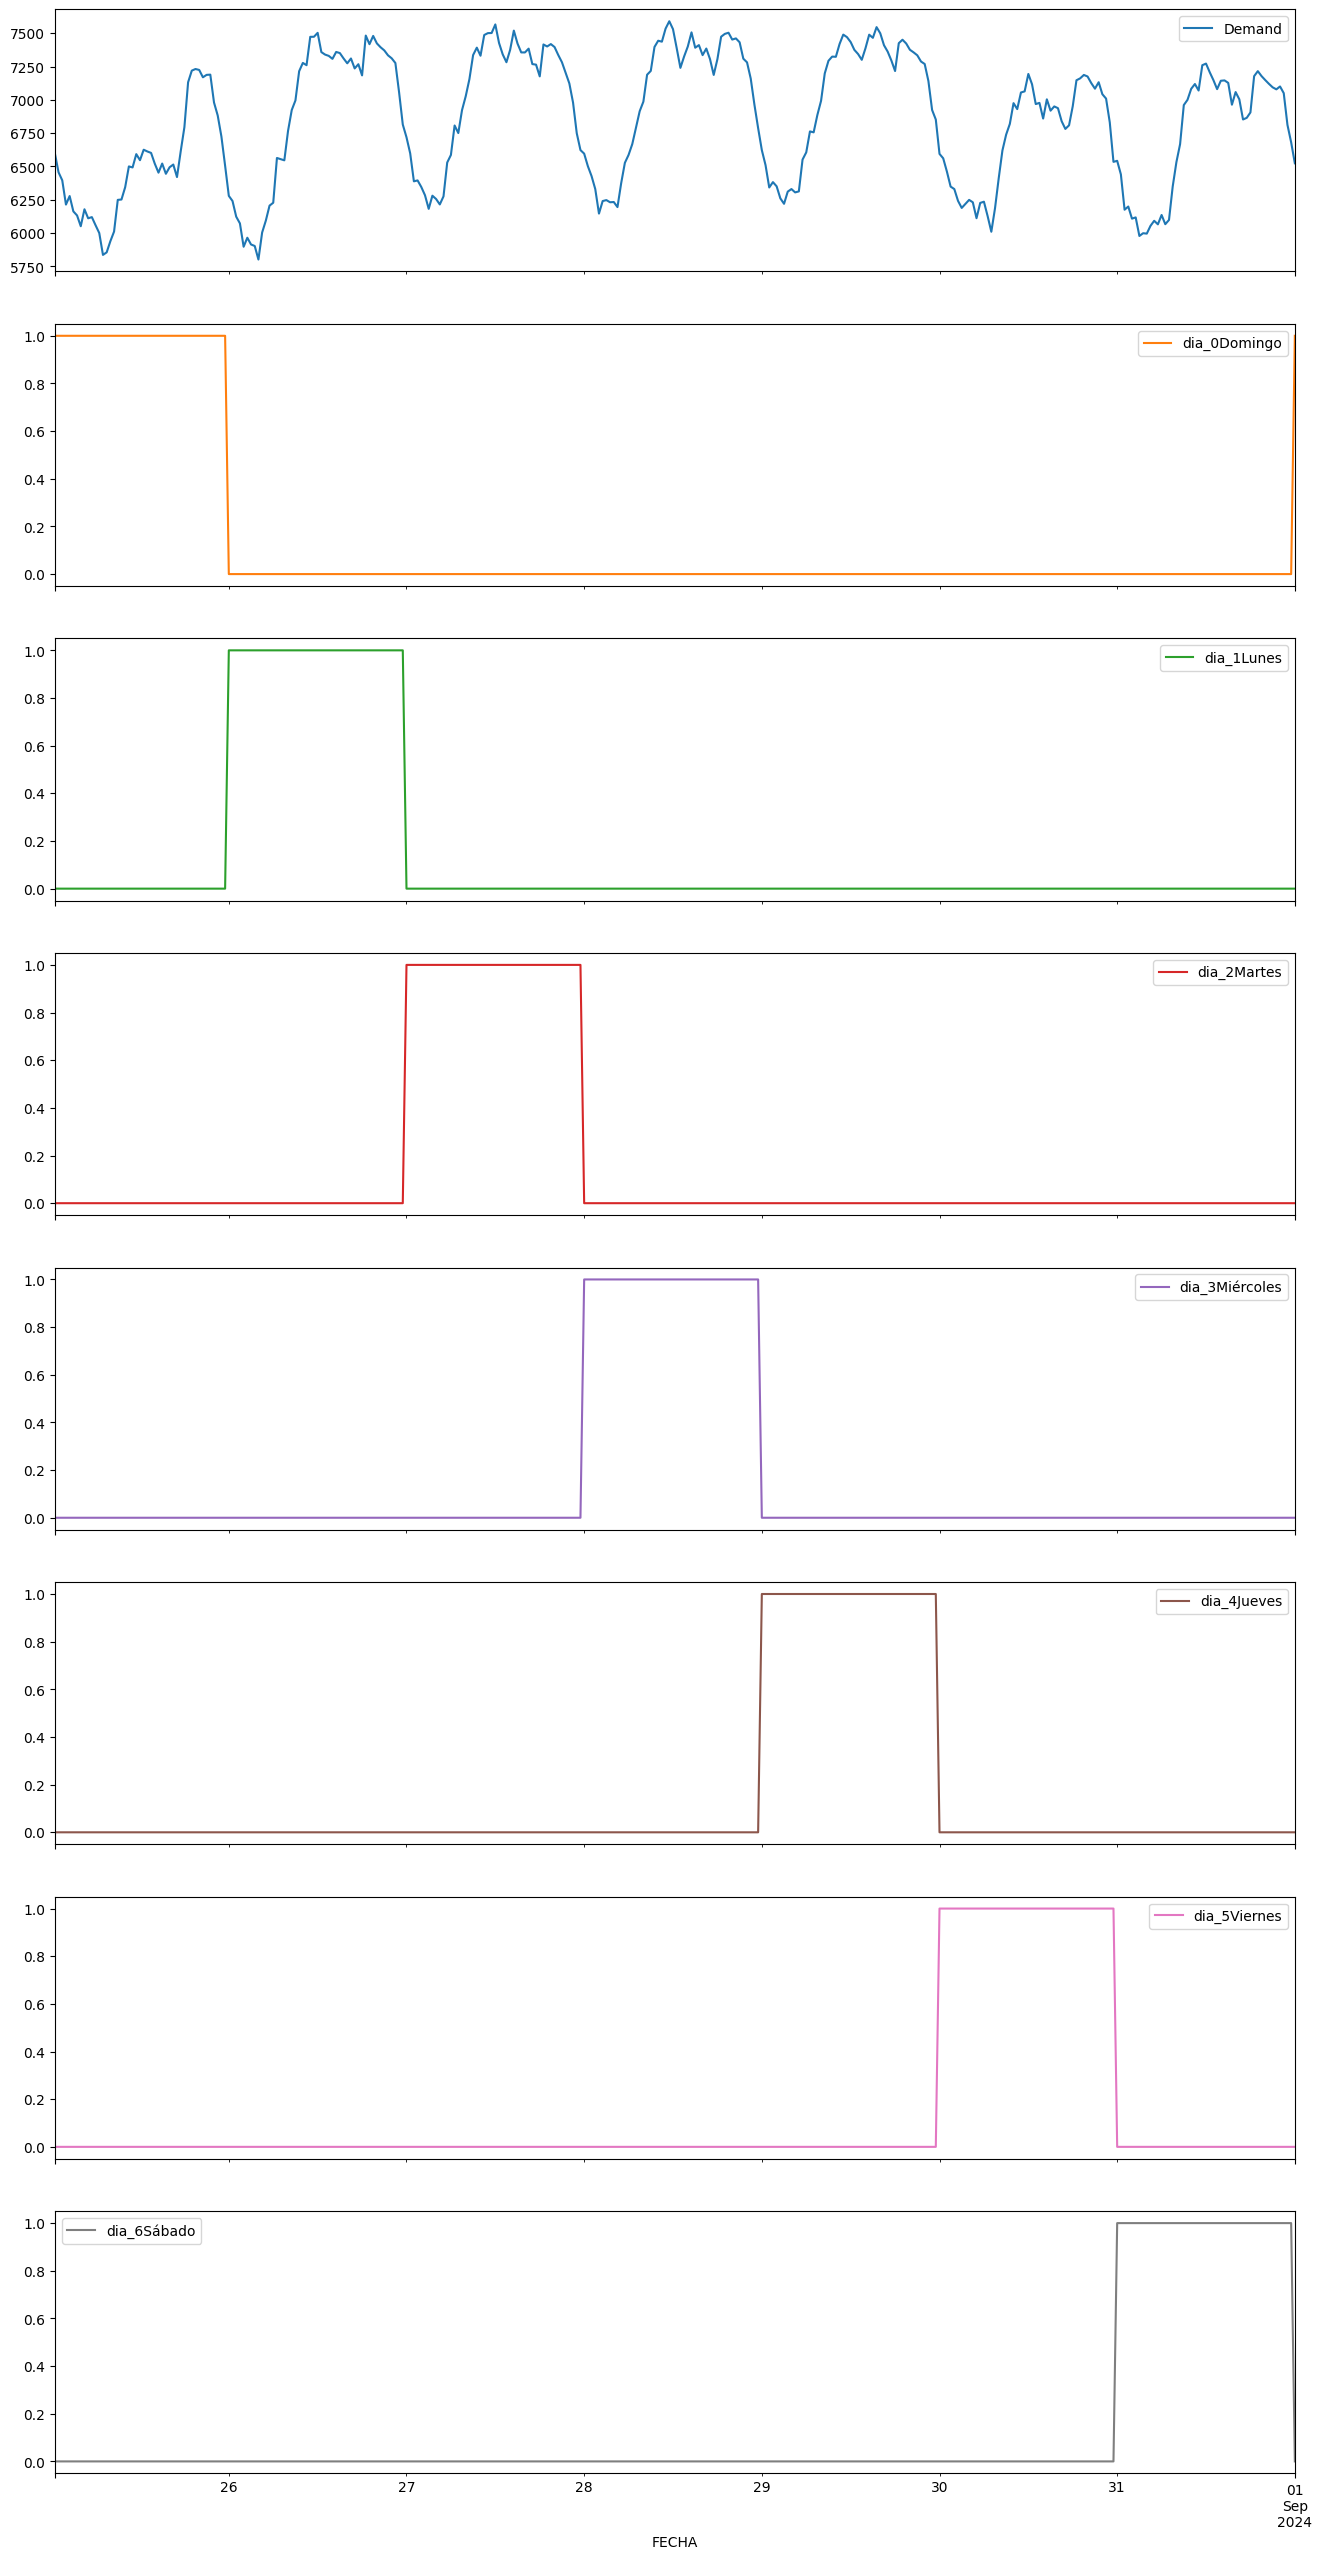

In [ ]:
data2[['Demand','dia_0Domingo','dia_1Lunes','dia_2Martes','dia_3Miércoles','dia_4Jueves','dia_5Viernes','dia_6Sábado']][-48*7:].plot(figsize=(16,32),subplots=True)
plt.show()

## EFECTO FERIADO

In [ ]:
pe = holidays.Peru(years=[2023, 2024], observed=True)
data2['feriado'] = data2.index.normalize().isin(pe).astype(int)

/tmp/ipython-input-1481387905.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data2['feriado'] = data2.index.normalize().isin(pe).astype(int)


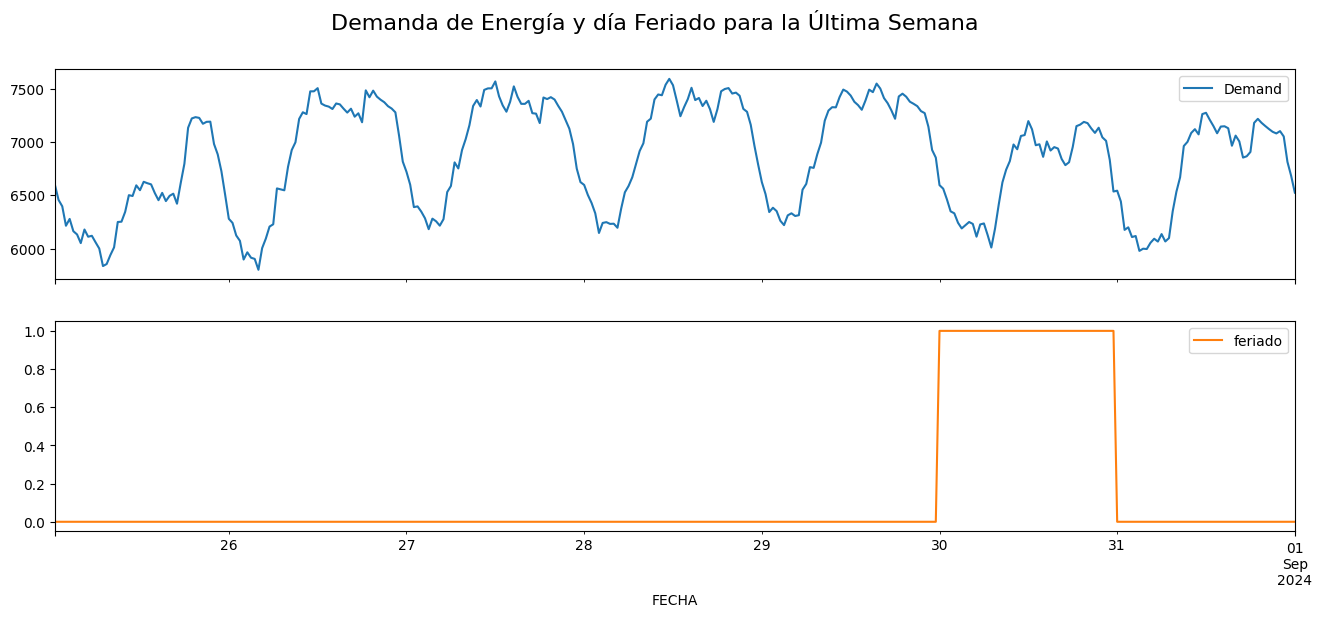

In [ ]:
data2[['Demand','feriado']][-48*7:].plot(figsize=(16,6),subplots=True)
plt.suptitle('Demanda de Energía y día Feriado para la Última Semana', fontsize=16)
plt.show()

## VISUALIZACIÓN CONSUMO ENERGÍA PROMEDIO POR HORA

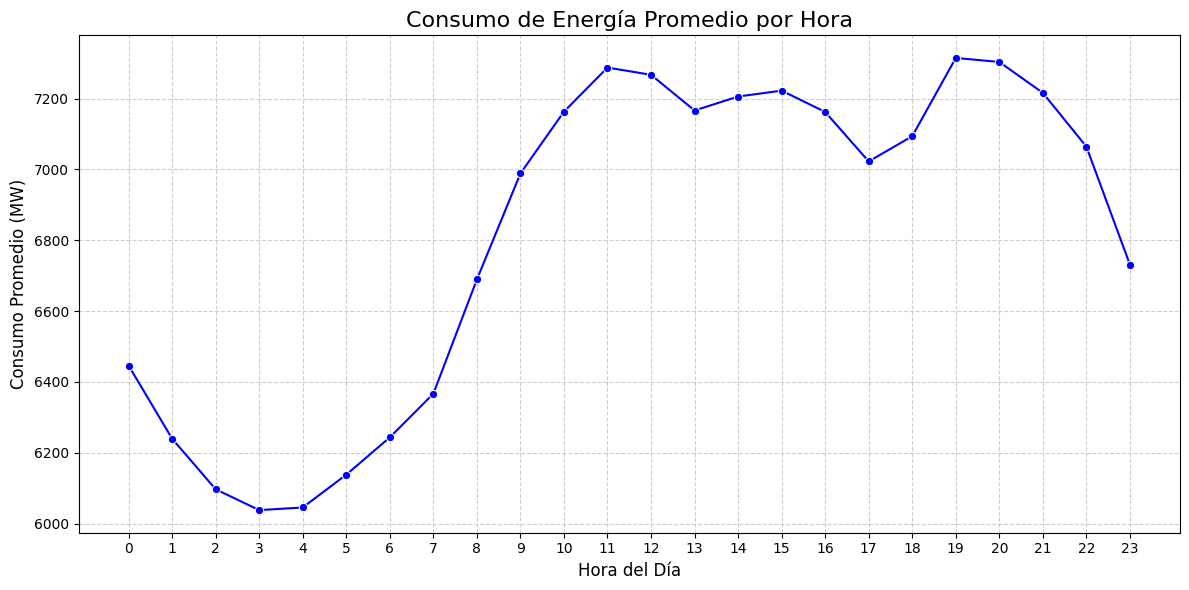

In [ ]:
data2['hour'] = data2.index.hour
# Agrupa por hora y calcular la demanda media
hourly_demand = data2.groupby('hour')['Demand'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_demand.index, y=hourly_demand.values, marker='o', color='b')
plt.title('Consumo de Energía Promedio por Hora', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Consumo Promedio (MW)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(hourly_demand.index)
plt.tight_layout()
plt.show()

## VISUALIZACIÓN CONSUMO DE ENERGÍA PROMEDIO POR DÍA DE LA SEMANA

USANDO DATA2 GRAFICANDO

VISUALIZACIÓN CONSUMO DE ENERGÍA PROMEDIO POR DÍA DE LA SEMANA

/tmp/ipython-input-943491152.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_demand.index, y=daily_demand.values, palette='viridis')


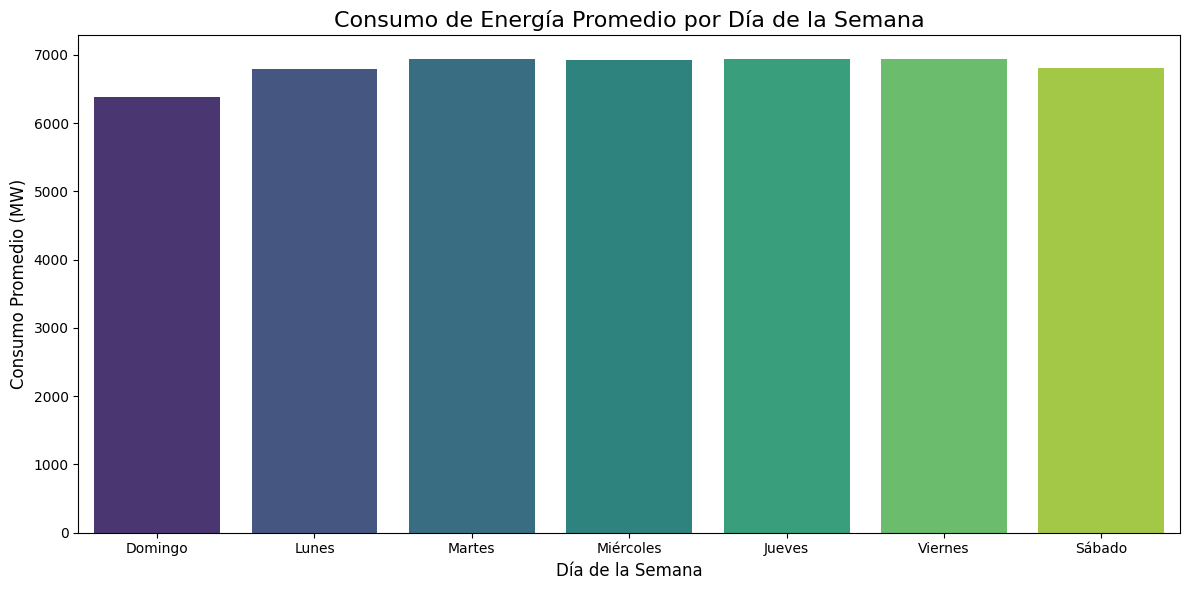

In [ ]:
# Identificar las nuevas variables ficticias para los días de la semana
day_columns = [col for col in data2.columns if col.startswith('dia_')]

# Calcular la demanda media para cada día de la semana utilizando las columnas ficticias
daily_demand_from_dummies = {}
for col in day_columns:
    # Filtrar el DataFrame donde la columna ficticia es 1 y calcular la media de 'Demanda'
    mean_demand = data2.loc[data2[col] == 1, 'Demand'].mean()
    # Almacenar el resultado con el nombre del día original como clave
    day_name = col.replace('dia_', '')
    daily_demand_from_dummies[day_name] = mean_demand

# Conviertir el diccionario en una serie de pandas y ordenarlo por el prefijo numérico
daily_demand = pd.Series(daily_demand_from_dummies)
daily_demand = daily_demand.sort_index()

# Graficar los datos
plt.figure(figsize=(12, 6))
sns.barplot(x=daily_demand.index, y=daily_demand.values, palette='viridis')
plt.title('Consumo de Energía Promedio por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Consumo Promedio (MW)', fontsize=12)
plt.xticks(ticks=np.arange(len(daily_demand.index)), labels=[d[1:] for d in daily_demand.index])
plt.tight_layout()

## VISUALIZACIÓN CONSUMO DE ENERGÍA PROMEDIO: DÍAS NORMALES VS. FERIADOS

/tmp/ipython-input-81867845.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data2['feriado'] = data2.index.normalize().isin(pe).astype(int)
/tmp/ipython-input-81867845.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_demand.index, y=holiday_demand.values, palette=['skyblue', 'salmon'])


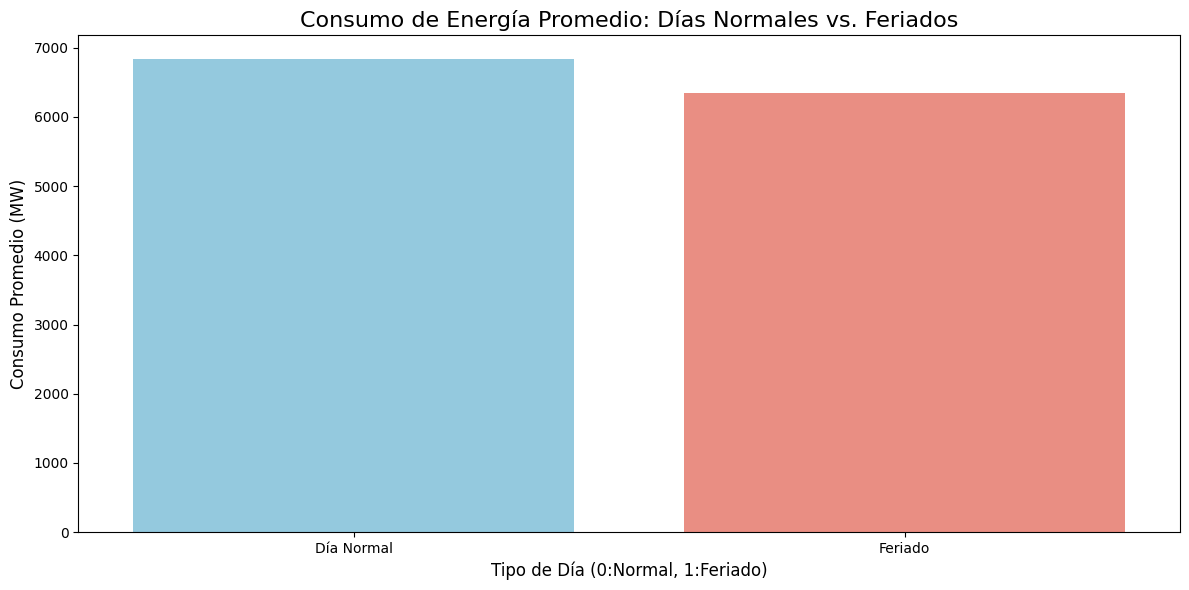

In [ ]:
pe = holidays.Peru(years=[2023, 2024], observed=True)
# Columna 'feriado' (1 para días festivos, 0 para días normales)
data2['feriado'] = data2.index.normalize().isin(pe).astype(int)

plt.figure(figsize=(12, 6))
# Agrupa por estado de vacaciones y calcula la demanda media
holiday_demand = data2.groupby('feriado')['Demand'].mean()
sns.barplot(x=holiday_demand.index, y=holiday_demand.values, palette=['skyblue', 'salmon'])
plt.title('Consumo de Energía Promedio: Días Normales vs. Feriados', fontsize=16)
plt.xlabel('Tipo de Día (0:Normal, 1:Feriado)', fontsize=12)
plt.ylabel('Consumo Promedio (MW)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Día Normal', 'Feriado'])
plt.tight_layout()
plt.show()

# PROYECTO FINAL

In [ ]:
data = pd.read_excel("DemandaCOES_.xlsx",skiprows=3)

In [ ]:
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d/%m/%Y %H:%M')
data.set_index('FECHA',inplace=True)
data.rename(columns={'EJECUTADO':'Demand'},inplace=True)
data = data.asfreq("30min")
data.head()

,Demand
FECHA,
2023-01-01 00:30:00,6120.78000
2023-01-01 01:00:00,6010.91339
2023-01-01 01:30:00,5946.83300
2023-01-01 02:00:00,5846.17000
2023-01-01 02:30:00,5756.13500


Feature Engineering (Exogenous Variables)

In [ ]:
def hora_minuto(hora,minuto):
  result = (hora * 60 + minuto) / (24 * 60)
  return result

data['ciclo'] = data.index.map(lambda t: (t.hour * 60 + t.minute) / (24 * 60))

days_translation = {
    'Monday': '1Lunes',
    'Tuesday': '2Martes',
    'Wednesday': '3Miércoles',
    'Thursday': '4Jueves',
    'Friday': '5Viernes',
    'Saturday': '6Sábado',
    'Sunday': '0Domingo'
}

data['dia'] = data.index.day_name().map(days_translation)
data2 = pd.get_dummies(data,columns=['dia'], dtype=int)

pe = holidays.Peru(years=[2023, 2024], observed=True)
data2['feriado'] = data2.index.normalize().isin(pe).astype(int)

/tmp/ipython-input-2476800573.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data2['feriado'] = data2.index.normalize().isin(pe).astype(int)


In [ ]:
data2.head()

,Demand,ciclo,dia_0Domingo,dia_1Lunes,dia_2Martes,dia_3Miércoles,dia_4Jueves,dia_5Viernes,dia_6Sábado,feriado
FECHA,,,,,,,,,,
2023-01-01 00:30:00,6120.78000,0.020833,1,0,0,0,0,0,0,1
2023-01-01 01:00:00,6010.91339,0.041667,1,0,0,0,0,0,0,1
2023-01-01 01:30:00,5946.83300,0.062500,1,0,0,0,0,0,0,1
2023-01-01 02:00:00,5846.17000,0.083333,1,0,0,0,0,0,0,1
2023-01-01 02:30:00,5756.13500,0.104167,1,0,0,0,0,0,0,1


Machine Learning Analysis (XGBoost with skforecast)

In [ ]:
# Crear y entrenar al pronosticador
regressor = XGBRegressor(n_estimators=250, max_depth=8, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 48
             )
forecaster.fit(y=data2.Demand)

<Axes: xlabel='FECHA'>

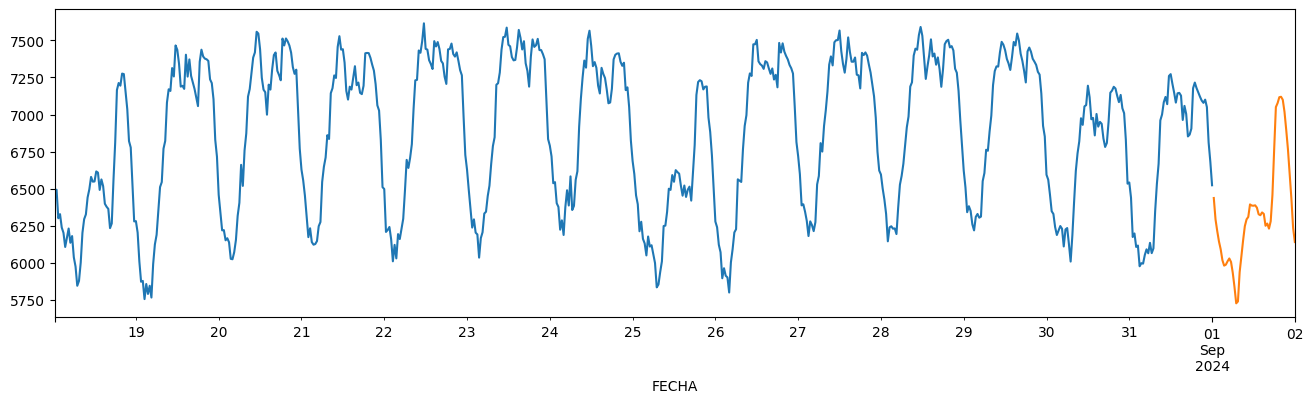

In [ ]:
# Hacer predicciones
data2.Demand[-(48*7*2):].plot(figsize=(16,4))
forecaster.predict(48).plot()

In [ ]:
# Dividir datos para ajustar y probar hiperparámetros
# steps = 48*7*4 # Para separar las últimas 4 semanas
steps = 48*7 # Para separar la última semana
x_train = data2.drop(columns=['Demand'])[:-steps]
x_test  = data2.drop(columns=['Demand'])[-steps:]
y_train = data2['Demand'][:-steps]
y_test  = data2['Demand'][-steps:]

In [ ]:
# Configuración de búsqueda de grid search
forecaster = ForecasterRecursive(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 48*7#esto es la memoria del modelo (una semana de datos)
             )

In [ ]:
# Pliegues de entrenamiento y validación grid search
# 48*7, # La evaluación se realizará por periodos de 1 semana.
cv = TimeSeriesFold(
      steps              = 48, # La evaluación es por periodos de 1 día.
      initial_train_size = int(len(x_train) - steps), # Iniciar evaluación desde hace una semana
      refit              = False,
      fixed_train_size   = False
    )

In [ ]:
# Valores candidatos para rezagos e hiperparámetros
lags_grid = [48,96,48*7]

In [ ]:
# ESTOS PARÁMETROS TARDARONS 3 HORAS 20 MINUTOS EN GRID SEARCH FORECASTER
"""# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250, 500, 750],
    'max_depth': [3, 5, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}"""

In [ ]:
param_grid = {
    'n_estimators': [250],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.05],
    #'subsample': [0.7, 0.9],
    #'colsample_bytree': [0.9]
}

In [ ]:
# Run grid search
results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = y_train,
                    cv          = cv,
                    exog        = x_train,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250}
  Backtesting metric: 8938.029978205772


In [ ]:
# PARÁMETROS OBTENIDOS
"""
`Forecaster` refitted using the best-found lags and parameters, and the whole data set:
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
  Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250}
  Backtesting metric: 8938.029978205772
  """

In [ ]:
# Entrenar el modelo final con los mejores parámetros
regressor = XGBRegressor(
    n_estimators=250,
    max_depth=8,
    learning_rate=0.05,
    #colsample_bytree=0.7,
    #subsample=0.7,
    random_state=123
)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 96
                              )
forecaster.fit(y=y_train,exog=x_train)

In [ ]:
# Hacer predicciones con el modelo final
predictions = forecaster.predict(#me va generar un pronostico de una semana hacia el futuro
                steps = steps,#cada 30 minutos hasta llegar a una semana
                exog  = x_test#el modelo va conocer los dias de la semana, la hora
              )

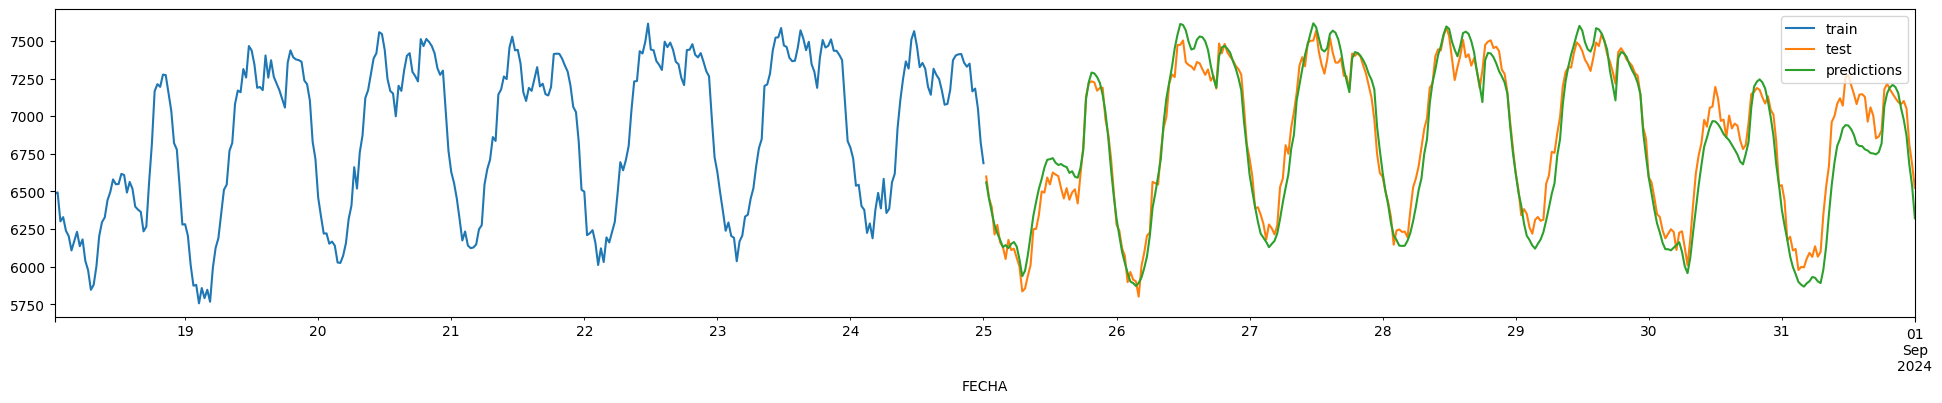

In [ ]:
# Graficar los resultados
fig, ax = plt.subplots(figsize=(24, 4))
y_train[-steps:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

EVALUACIÓN

In [ ]:
# Calcular el error cuadrático medio para el modelo de aprendizaje automático
error_mse1 = mean_squared_error(
                y_true = y_test,
                y_pred = predictions
            )
print(f"Test error 1 (MSE): {error_mse1}")

# Calcular Root Mean Squared Error (RMSE)
error_rmse = np.sqrt(error_mse1)

print(f"Root Mean Squared Error (RMSE): {error_rmse}")

Test error 1 (MSE): 17162.59314325616
Root Mean Squared Error (RMSE): 131.00608055833194


In [ ]:
# MAE es el promedio de las diferencias absolutas entre las predicciones y los valores reales.
# Es menos sensible a los valores atípicos que el RMSE.
mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f} Megawatts")

Mean Absolute Error (MAE): 104.45 Megawatts


In [ ]:
### 1. Mean Absolute Percentage Error (MAPE)
# Esta es una buena medida de "precisión promedio" en términos porcentuales.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filtra los valores actuales que sean cero para evitar errores de división por cero
    non_zero_elements = y_true != 0
    if not np.any(non_zero_elements):
        return np.nan # O 0, dependiendo de cómo quieras manejar todos los ceros

    return np.mean(np.abs((y_true[non_zero_elements] - y_pred[non_zero_elements]) / y_true[non_zero_elements])) * 100

# Calcular MAPE
# Asegurarse de que y_test y las predicciones estén definidas en el alcance de su cuaderno
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# 100 - 1.54 = 98.46% Preciso

Mean Absolute Percentage Error (MAPE): 1.54%
